In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: QBC evaluation with any stays

**02.09.2020**

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
from synthetic_data.trajectory_class import get_pickle_trajectory
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays

In [7]:
from stay_classification.box_classifier.quick_box_classifier import quick_box_method

# Batch data evaluation

In [8]:
dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [9]:
time_thresh = 1/6
dist_thresh=0.25

In [10]:
nr_stays = 3

In [11]:
data_dir = os.path.abspath('../..')+f"/testdata/testdata_training_set__general/"

if os.path.isdir(data_dir):
    print('exists')
        
pkls = [pkl for pkl in os.listdir(data_dir) if 'plots' not in pkl ]   


exists


In [15]:
import glob
data_dir = os.path.abspath('../../')+f"/testdata/testdata_training_set__general/"
os.path.isdir(data_dir)
pkls = glob.glob(data_dir + "*.pkl")

In [16]:
from stay_classification.metrics_etc import eval_synth_data
from stay_classification.metrics import get_segments_scores, get_segments_errs
from stay_classification.metrics_cluster_tools import get_pred_labels, get_labels_from_clusters

In [17]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays

get_err = lambda trues, preds: np.sum(abs(trues-preds))/trues.size

## Load, Classify, Measure

In [18]:
# For the correct nr of stays
lens3 = []
precs3, a_precs3, w_precs3 = [], [], []
recs3, a_recs3, w_recs3 = [], [], []
errs3, a_errs3, w_errs3 = [], [], []

# For the incorrect nr of stays
lens = []
precs, a_precs, w_precs = [], [], []
recs, a_recs, w_recs = [], [], []
errs, a_errs, w_errs = [], [], []


bad_list = []

precrec_limit = 0.80

ii = 0

length_criterion_break = False
iqr_trim = False
verbose = False

total = 1000

for ii in range(0, total):
    
    # Load the data
    trajectory_tag = pkls[ii]   
    path_to_file =  pkls[ii]   #data_dir + trajectory_tag
    t_arr, r_arr, x_arr, segments = get_pickle_trajectory(path_to_file)
    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

    # Get the true event indices (needed for the total error)
    true_indices = get_stay_indices(get_adjusted_stays(segments, t_arr), t_arr)
    true_labels = np.zeros(t_arr.shape)
    for pair in true_indices:
        true_labels[pair[0]:pair[1]+1] = 1
    
    # Get the stay clusters
    clusters = quick_box_method(t_arr, x_arr, dist_thresh, time_thresh, 1, False)    
    
    # Make some measurements
    final_len=len(clusters)
    # total scores
    prec, rec, conmat = eval_synth_data(t_arr, segments, clusters)
    # seg. scores
    _, a_prec, w_prec, _, a_rec, w_rec = get_segments_scores(t_arr, segments, clusters)   
    
    # Total error
    pred_labels = get_pred_labels(clusters, t_arr.shape)
    err = get_err(true_labels,pred_labels)
    # Segment errors
    _, a_err, w_err = get_segments_errs(t_arr, segments, clusters)
    
    # Get the expected number of stays (in general)
    stays_tag = int((x_segs.size)/3)
    
    len_all_clusts = len(clusters)
    if final_len != stays_tag:
        lens.append(final_len)
        precs.append(prec)
        a_precs.append(a_prec)
        w_precs.append(w_prec)
        recs.append(rec)        
        a_recs.append(a_rec)        
        w_recs.append(w_rec)
        errs.append(err)        
        a_errs.append(a_err)        
        w_errs.append(w_err)                
    else:
        lens3.append(final_len)
        precs3.append(prec)
        a_precs3.append(a_prec)
        w_precs3.append(w_prec)
        recs3.append(rec)        
        a_recs3.append(a_rec)        
        w_recs3.append(w_rec)        
        errs3.append(err)        
        a_errs3.append(a_err)
        w_errs3.append(w_err)
    
    # progress output
    if ii % int(0.1*total) == 0:
        print(f"{ii:4d} of {total:5d}")

   0 of  1000
 100 of  1000
 200 of  1000
 300 of  1000
 400 of  1000
 500 of  1000
 600 of  1000
 700 of  1000
 800 of  1000
 900 of  1000


In [20]:
correct_frac = (len(lens3)/total)
incorrect_frac = (len(lens)/total)

In [21]:
print(f"\n    * correct number of stays, {correct_frac:6.3f} ", 
      f"\n        * prec.: {sum(w_precs3)/len(w_precs3):6.3}",
      f"\n        *  rec.: {sum(w_recs3)/len(w_recs3):6.3}",
      f"\n    * incorrect number of stays, {incorrect_frac:6.3f}",
      f"\n        * prec.: {sum(w_precs)/len(w_precs):6.3}",
      f"\n        *  rec.: {sum(w_recs)/len(w_recs):6.3}")


    * correct number of stays,  0.665  
        * prec.:  0.993 
        *  rec.:  0.993 
    * incorrect number of stays,  0.335 
        * prec.:   0.98 
        *  rec.:  0.466


## Visualizations

In [22]:
from stay_classification.metrics_plotting import plot_scores_stats, plot_errs_stats, plot_scores_stats_cominbed

In [23]:
print(f"Correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}")

Correct stays,  0.665; incorrect stays,  0.335


### Prec/rec score distributions

#### Total scores

In [24]:
nr_stays = 'gen_'

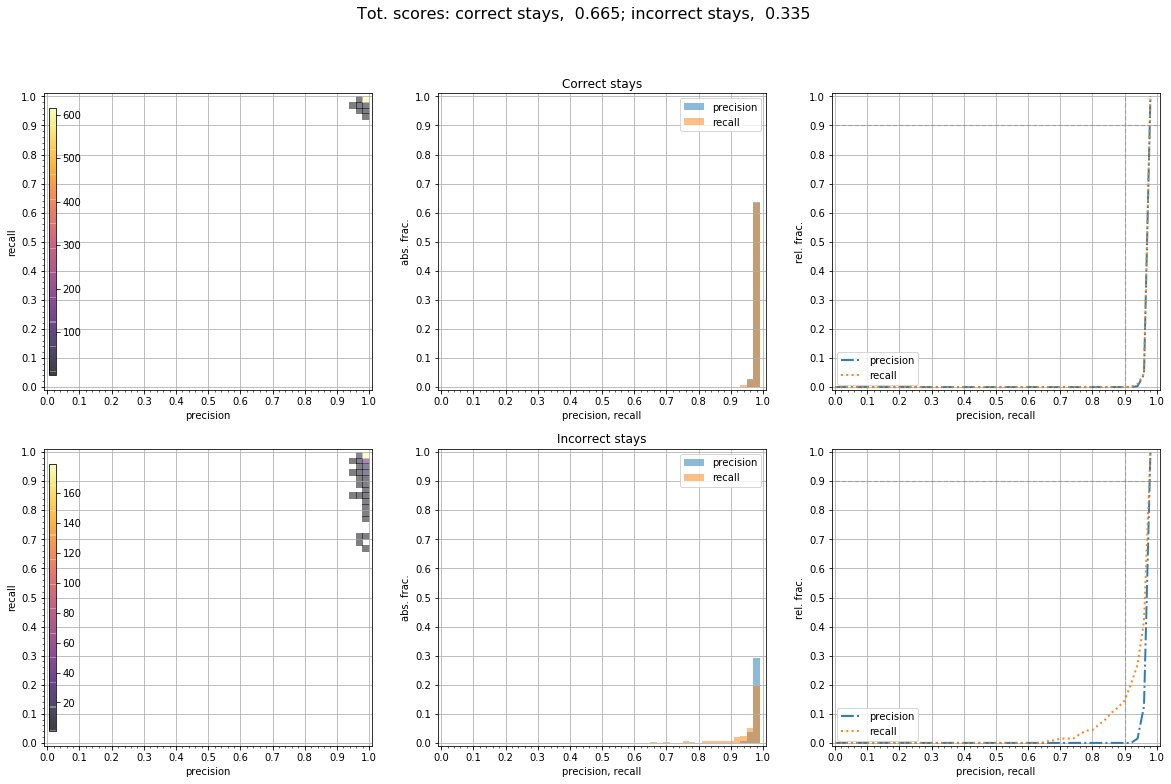

In [25]:
title = f"Tot. scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats(precs3, recs3, precs, recs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays.png")

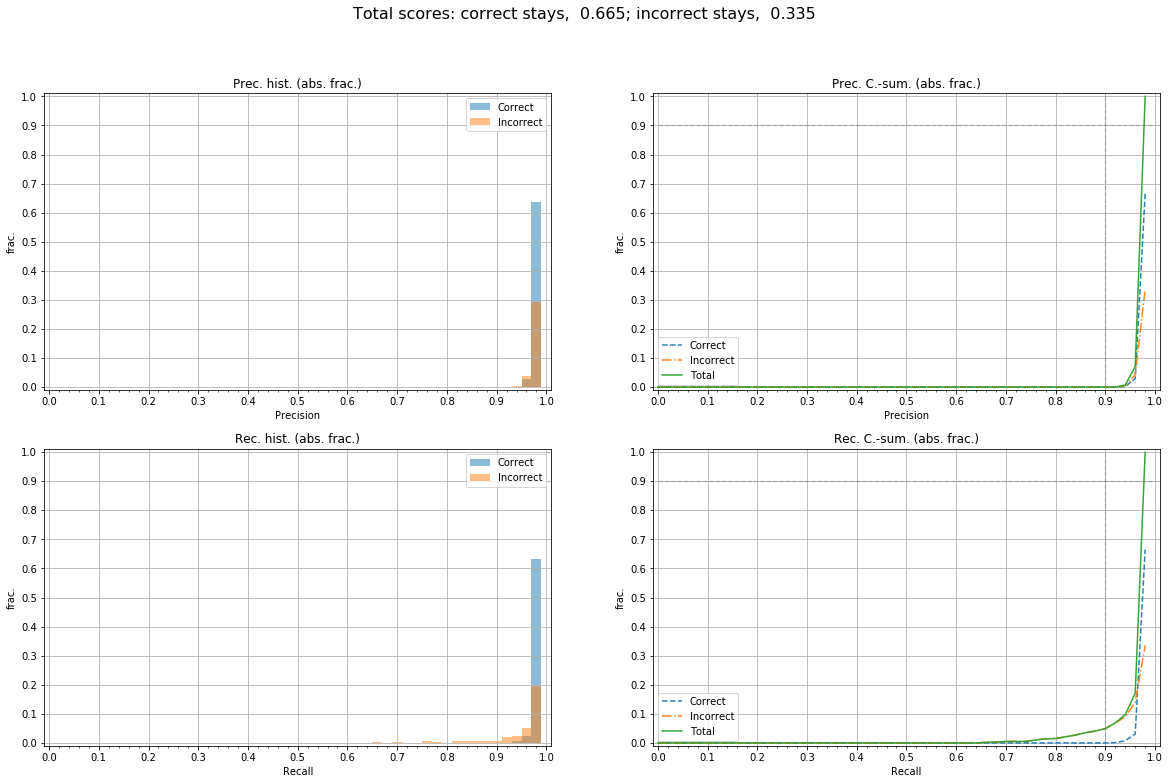

In [26]:
title = f"Total scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats_cominbed(precs3, recs3, precs, recs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays_seg_scores_combined_tot.png")

#### Segment-averaged score distributions

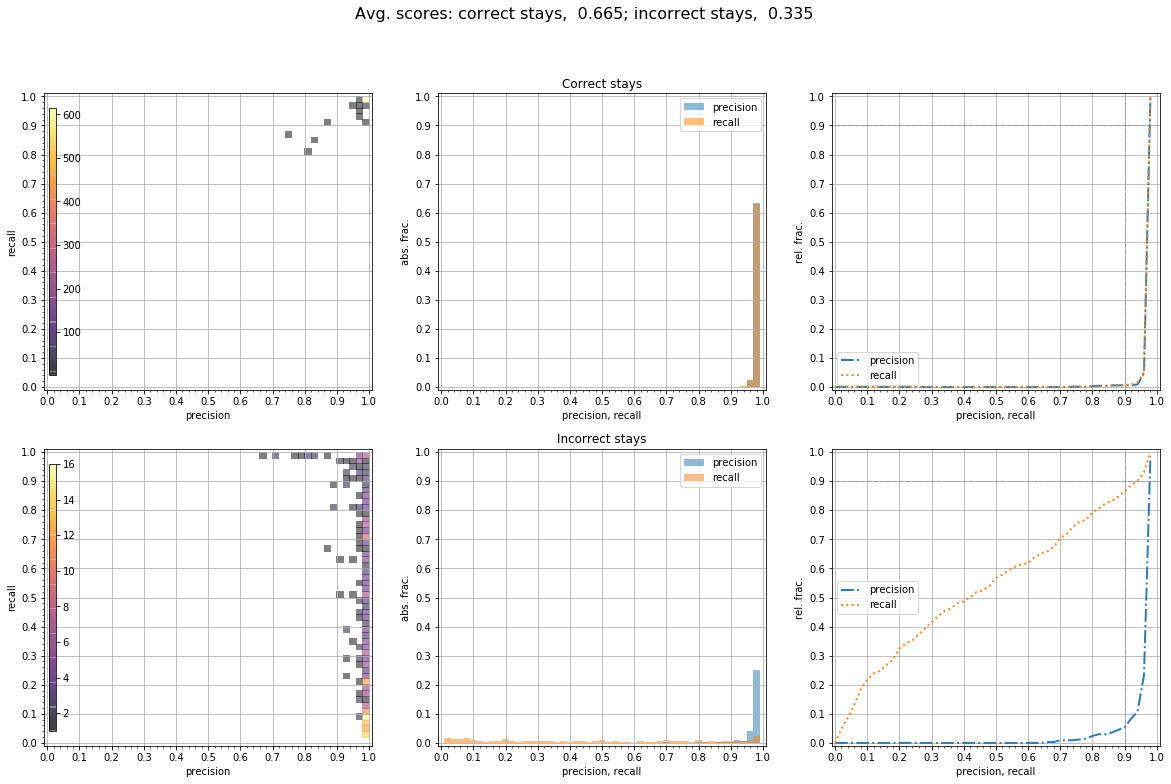

In [27]:
title = f"Avg. scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats(a_precs3, a_recs3, a_precs, a_recs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays_seg_scores_avg.png")

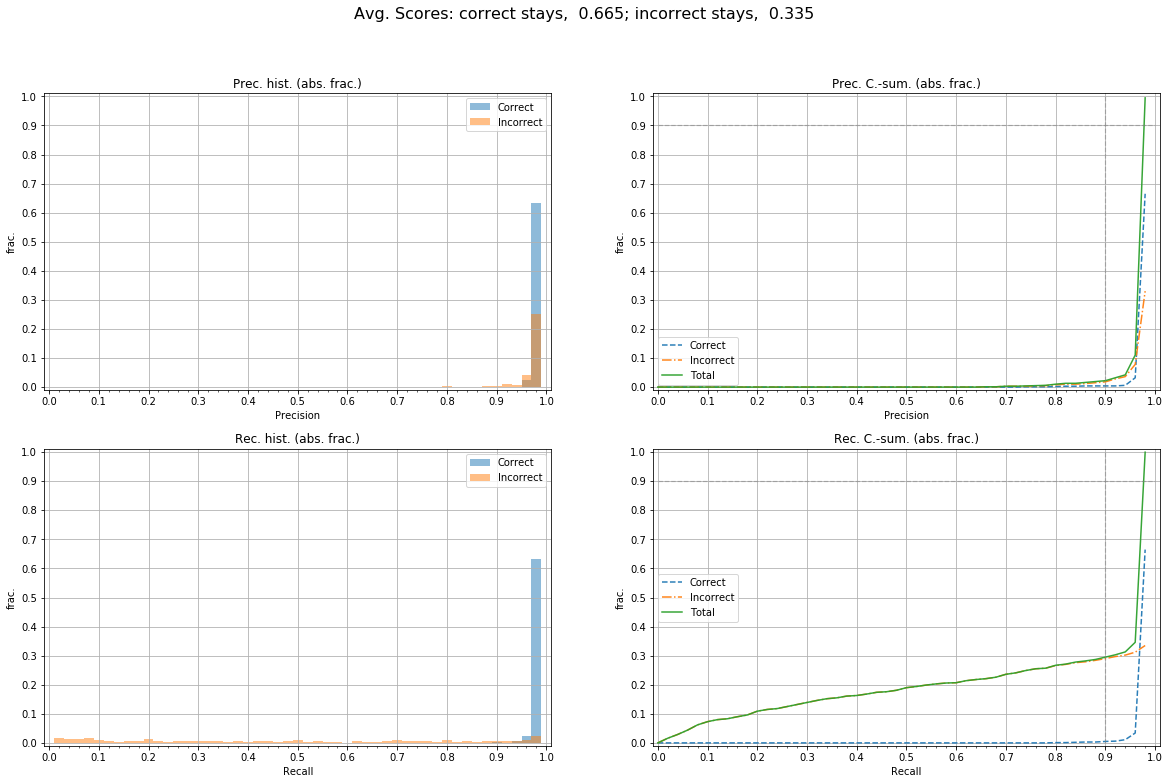

In [28]:
title = f"Avg. Scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats_cominbed(a_precs3, a_recs3, a_precs, a_recs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays_seg_scores_combined_avg.png")

#### Segment, weighted-averaged score distributions

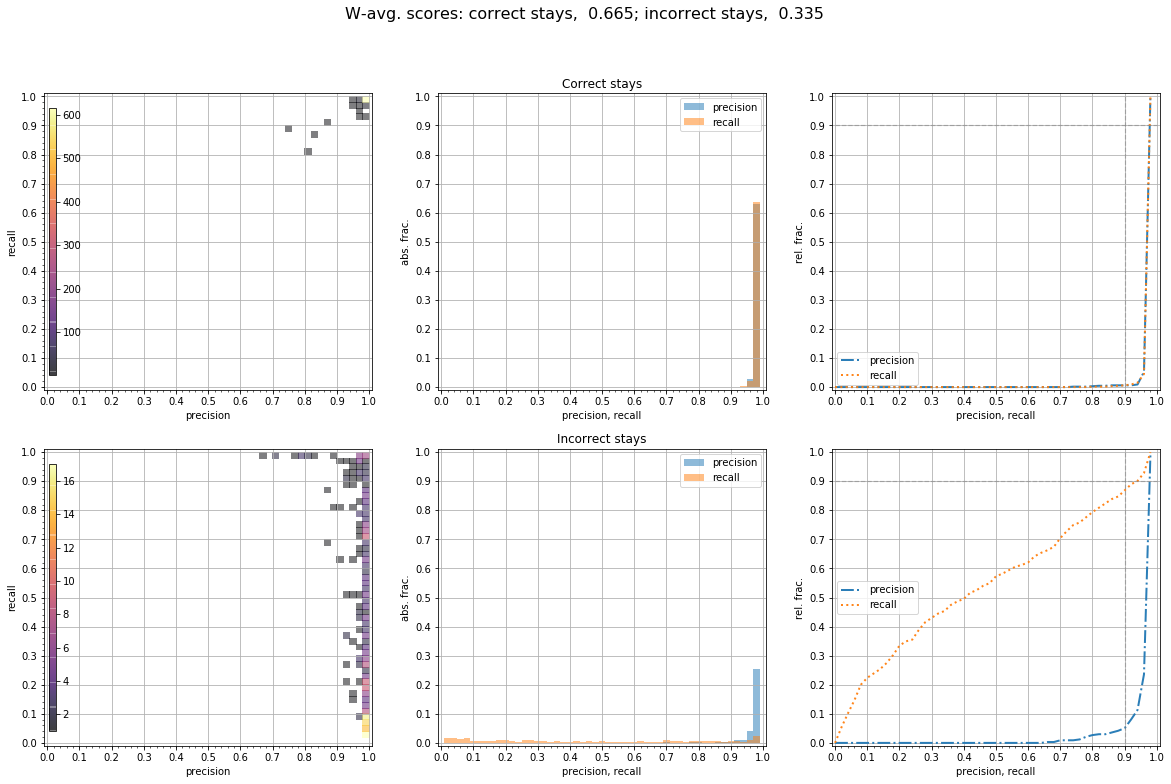

In [29]:
title = f"W-avg. scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats(w_precs3, w_recs3, w_precs, w_recs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays_seg_scores_wavg.png")

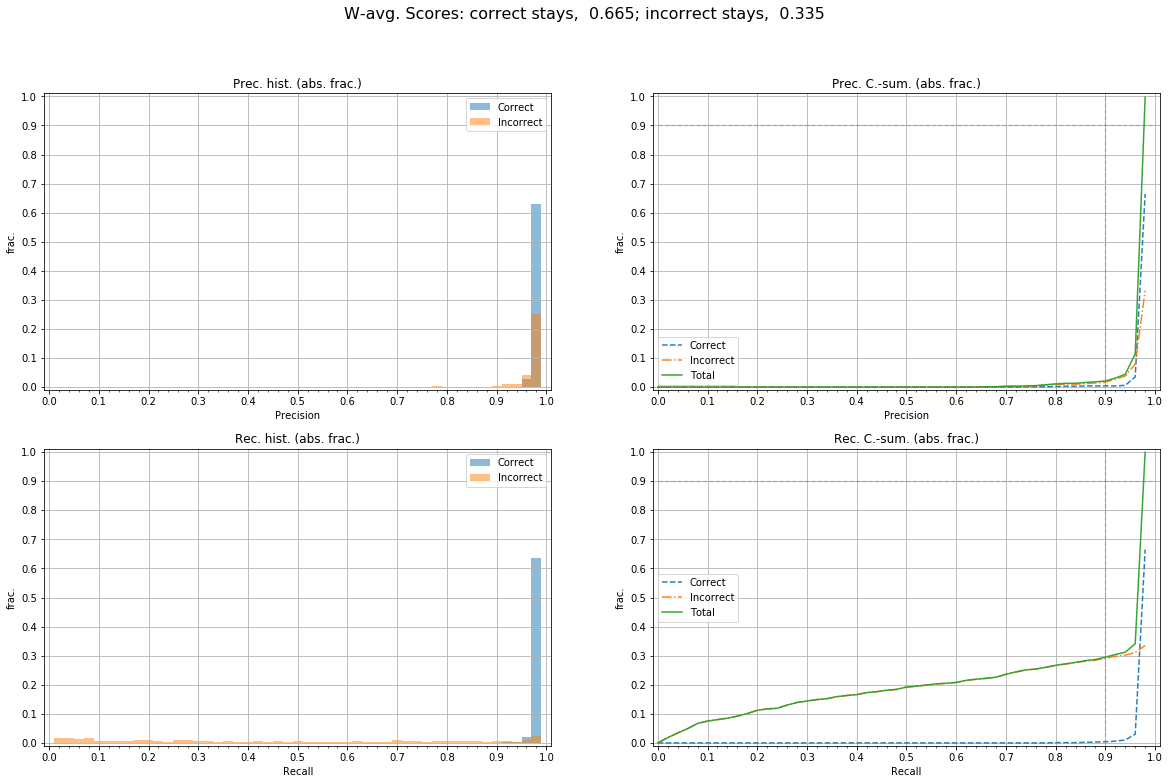

In [30]:
title = f"W-avg. Scores: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, axs = plot_scores_stats_cominbed(w_precs3, w_recs3, w_precs, w_recs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays_seg_scores_combined_wavg.png")

### Error stats

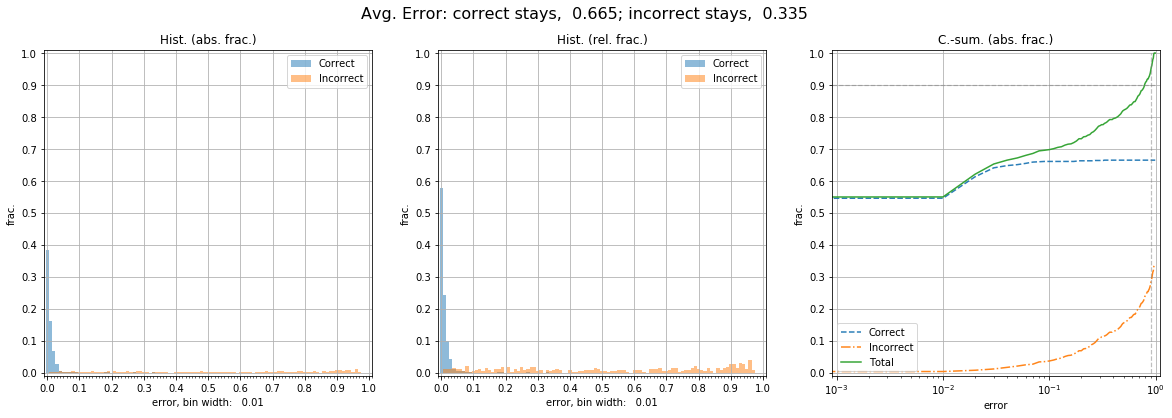

In [31]:
title = f"Avg. Error: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, ax = plot_errs_stats(a_errs3, a_errs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays_seg_errs_avg.png")

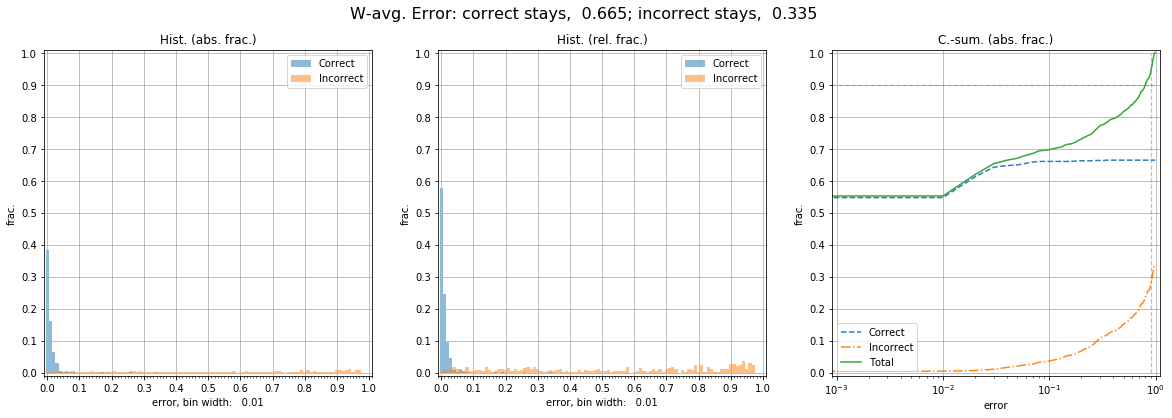

In [32]:
title = f"W-avg. Error: correct stays, {correct_frac:6.3f}; incorrect stays, {incorrect_frac:6.3f}"

fig, ax = plot_errs_stats(w_errs3, w_errs, title)

fig.savefig("./" + f"metrics__{nr_stays}stays_seg_errs_wavg.png")

---